### Download data on host machine

In [52]:
%%bash
mkdir /storage/data-science-bowl-2018
mkdir /storage/data-science-bowl-2018/input
kaggle competitions download data-science-bowl-2018 -p /storage/data-science-bowl-2018/input
cd /storage/data-science-bowl-2018/input

mkdir: cannot create directory ‘/media/andrew/HDD1/Data/data-science-bowl-2018’: File exists
mkdir: cannot create directory ‘/media/andrew/HDD1/Data/data-science-bowl-2018/input’: File exists
100%|██████████| 2.62k/2.62k [00:00<00:00, 3.85MB/s]
100%|██████████| 2.67M/2.67M [00:00<00:00, 21.7MB/s]
100%|██████████| 9.10M/9.10M [00:00<00:00, 100MB/s]
100%|██████████| 79.1M/79.1M [00:00<00:00, 110MB/s]
100%|██████████| 112k/112k [00:00<00:00, 11.5MB/s]
100%|██████████| 276M/276M [00:02<00:00, 112MB/s]
100%|██████████| 386k/386k [00:00<00:00, 12.7MB/s]


In [53]:
%%bash
shopt -s globstar
for gz_file in /media/andrew/HDD1/Data/data-science-bowl-2018/input/*.zip; do
    name=$(echo "$gz_file" | cut -f 1 -d '.')
    echo "$name"
    unzip "$gz_file" -d "$name"
    rm -rf "$gz_file"
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Import dependencies
    - tqdm
    - itertools
    - scikit-image
    - tensorflow
    - keras

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [6]:
print(v[0] for v in os.walk(os.getcwd()))

<generator object <genexpr> at 0x7f95991ff4c0>


### Parameters

In [2]:
# Set some parameters

#Desired image width/height
IMG_WIDTH = 128
IMG_HEIGHT = 128

IMG_CHANNELS = 3
TRAIN_PATH = '/media/andrew/HDD1/Data/data-science-bowl-2018/input/stage1_train/'
TEST_PATH = '/media/andrew/HDD1/Data/data-science-bowl-2018/input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Get train and test IDs

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

### Get and process Data

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:14<00:00,  8.97it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 90.73it/s]

Done!


### See if data looks ok

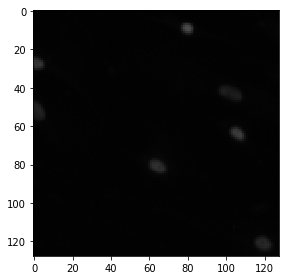

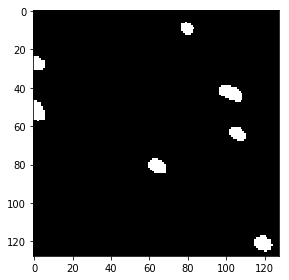

In [67]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

### Mean IOU Metric

In [4]:
def Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.to_int32(true_labels & pred_labels)
        union = tf.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.to_int32(true_labels), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.debugging.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)

### Build Unet Model

In [88]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Mean_IOU])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

In [95]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<img style="float:left;transform: rotate(45deg); width:600px" src="model_plot.png" />


### Train Model

In [71]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 48s 79ms/step - loss: 0.3548 - Mean_IOU: nan - val_loss: 0.2290 - val_Mean_IOU: nan

Epoch 00001: val_loss improved from inf to 0.22898, saving model to model-dsbowl2018-1.h5
Epoch 2/50
603/603 [==============================] - 31s 52ms/step - loss: 0.1745 - Mean_IOU: nan - val_loss: 0.1453 - val_Mean_IOU: nan

Epoch 00002: val_loss improved from 0.22898 to 0.14529, saving model to model-dsbowl2018-1.h5
Epoch 3/50
603/603 [==============================] - 31s 52ms/step - loss: 0.1363 - Mean_IOU: nan - val_loss: 0.1240 - val_Mean_IOU: nan

Epoch 00003: val_loss improved from 0.14529 to 0.12397, saving model to model-dsbowl2018-1.h5
Epoch 4/50
603/603 [==============================] - 32s 53ms/step - loss: 0.1192 - Mean_IOU: nan - val_loss: 0.1291 - val_Mean_IOU: nan

Epoch 00004: val_loss did not improve from 0.12397
Epoch 5/50
603/603 [==============================] - 32s 53ms/step - 

### Predict

In [78]:
# Predict on train, val and test
#model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': Mean_IOU})
model = load_model('model-dsbowl2018-1.h5', custom_objects={'Mean_IOU': Mean_IOU})

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 2s 25ms/step


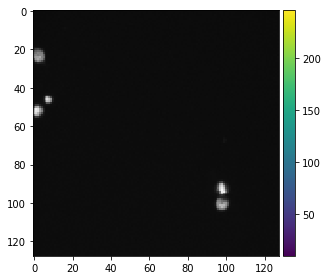

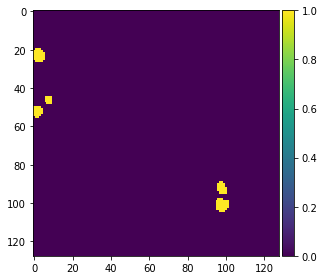

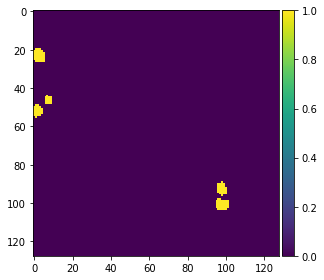

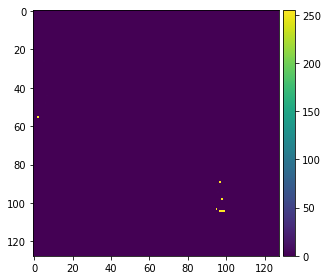

In [100]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix])-np.squeeze(Y_train[ix]))
plt.show()

In [105]:
from keras.preprocessing import image as image_k

In [164]:
ix = random.randint(0, len(preds_train_t))
img = X_train[ix,:,:,:]
img_tensor = image_k.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
#imshow(img)

layer_outputs = [layer.output for layer in model.layers] # Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(X_test) # Returns a list of five Numpy arrays: one array per layer activation


layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    #plt.figure(figsize=(scale * display_grid.shape[1],
    #                    scale * display_grid.shape[0]))
    #plt.title(layer_name)
    #plt.grid(False)
    print(layer_name)
    imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

InvalidArgumentError: input_3:0 is both fed and fetched.

In [163]:
model.input

<tf.Tensor 'input_3:0' shape=(?, 128, 128, 3) dtype=float32>

In [171]:
def getConvOutput(model,index=-1):
    # index=-1 means last convolutional layer
    layers = model.layers
    return [layer.output for layer in layers][index]
    #return [layer.output for layer in layers if type(layer) is tf.keras.layers.Conv2D][index]

In [19]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'Mean_IOU': Mean_IOU})

In [13]:
#https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py
"""
#Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes.
Results example: ![Visualization](http://i.imgur.com/4nj4KjN.jpg)
"""
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K


def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(128, 128),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.
    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    #assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)




In [18]:
visualize_layer(model, 'conv2d_42')

KeyError: 'conv2d_42'

In [23]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict.keys()
layer_dict['conv2d_22']

In [6]:
import multiprocessing as mp

model = load_model('model-dsbowl2018-1.h5', custom_objects={'Mean_IOU': Mean_IOU})
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layernames = layer_dict.keys()

In [7]:
result_list=[]
def log_result(result):
    result_list.append(result)
    
def apply_async_with_callback():
    pool=mp.Pool();
    for layername in layernames:
        if "conv2d" in layername:
            pool.apply_async(vn.visualize_layer, args = (layername,))
    pool.close()
    pool.join()
    print(result_list)

if __name__ == '__main__':
    apply_async_with_callback()    
   

KeyboardInterrupt: 

In [15]:
for layername in layernames:
    if "conv2d" in layername:
        try:
            visualize_layer(model,layername)
        except:
            pass

Compute filters 0 to 16
Costs of filter   9:     0 ( 0.74s )
1 filter processed.
Compute filters 0 to 16
0 filter processed.
Compute filters 0 to 32
Costs of filter   1:     1 ( 1.43s )
Costs of filter  25:     1 ( 1.19s )
Costs of filter  31:     1 ( 1.25s )
3 filter processed.
Compute filters 0 to 32
Costs of filter   1:     3 ( 1.57s )
Costs of filter   7:     1 ( 1.48s )
Costs of filter  15:     2 ( 1.57s )
Costs of filter  16:     1 ( 1.52s )
Costs of filter  20:     2 ( 1.47s )
Costs of filter  21:     2 ( 1.56s )
Costs of filter  28:     1 ( 1.60s )
7 filter processed.
Compute filters 0 to 64
Costs of filter   4:     2 ( 1.80s )
Costs of filter   6:     3 ( 1.72s )
Costs of filter  12:     4 ( 1.77s )
Costs of filter  13:     3 ( 1.78s )
Costs of filter  18:     1 ( 1.77s )
Costs of filter  27:     5 ( 1.88s )
Costs of filter  28:     4 ( 1.92s )
Costs of filter  29:     2 ( 1.91s )
Costs of filter  36:     5 ( 1.94s )
Costs of filter  54:     3 ( 2.03s )
Costs of filter  57:   

In [10]:
layernames

dict_keys(['lambda_2', 'conv2d_20', 'dropout_10', 'conv2d_21', 'max_pooling2d_5', 'conv2d_22', 'dropout_11', 'conv2d_23', 'max_pooling2d_6', 'conv2d_24', 'dropout_12', 'conv2d_25', 'max_pooling2d_7', 'conv2d_26', 'dropout_13', 'conv2d_27', 'max_pooling2d_8', 'conv2d_28', 'dropout_14', 'conv2d_29', 'conv2d_transpose_5', 'concatenate_5', 'conv2d_30', 'dropout_15', 'conv2d_31', 'conv2d_transpose_6', 'concatenate_6', 'conv2d_32', 'dropout_16', 'conv2d_33', 'conv2d_transpose_7', 'concatenate_7', 'conv2d_34', 'dropout_17', 'conv2d_35', 'conv2d_transpose_8', 'concatenate_8', 'conv2d_36', 'dropout_18', 'conv2d_37', 'conv2d_38'])

In [ ]:
import 